# ホログラムMNISTの識別プログラム

### ライブラリ宣言

In [1]:
import tensorflow as tf
import keras
import numpy as np
from trans_holo import asm
import matplotlib.pyplot as plt
import gc

### MNISTのDL

In [2]:
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

num_train = 10
num_test = 10
x_train = x_train[:num_train]
x_test = x_test[:num_test]
y_train = y_train[:num_train]
y_test = y_test[:num_test]
print(x_train.shape)
print(x_test.shape)

(10, 28, 28)
(10, 28, 28)


### 画像出力関数

In [3]:
def imprint(f):
    fig = plt.figure(figsize = (20, 2))
    n = 10
    for i in range(10):
        ax = plt.subplot(1, n, i+1)
        plt.imshow(f[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

### 画像拡大関数

In [4]:
def expand(f, ex, ax):
    f_ex = f.repeat(ex, axis=ax)
    return f_ex

In [5]:
ex = 8
x_train_ex = expand(expand(x_train, ex, 1), ex, 2)
x_test_ex = expand(expand(x_test, ex, 1), ex, 2)
print(x_train_ex.shape)
print(x_test_ex.shape)

(10, 224, 224)
(10, 224, 224)


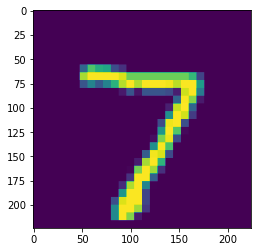

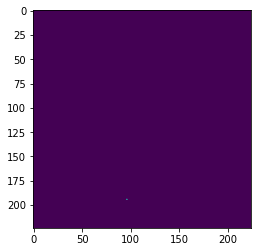

In [6]:
holo_train = np.zeros_like(x_train_ex)
holo_test = np.zeros_like(x_test_ex)

z = 0.05
for i in range(num_train):
  holo_train[i] = asm(x_train_ex[i], z, 532E-9)[0]

for j in range(num_test):
  holo_test[j] = asm(x_test_ex[j], z, 532E-9)[0]

plt.imshow(x_test_ex[0])
plt.show()
plt.imshow(holo_test[0].real)
plt.show()

### ゼロパディング

In [7]:
def padding(f):
    f2 = np.zeros((f.shape[0]*2, f.shape[1]*2), dtype=np.complex64)
    f2[int(f2.shape[0]/2-f.shape[0]/2):int(f2.shape[0]/2+f.shape[0]/2),
           int(f2.shape[1]/2-f.shape[1]/2):int(f2.shape[1]/2+f.shape[1]/2)] = f
    return f2

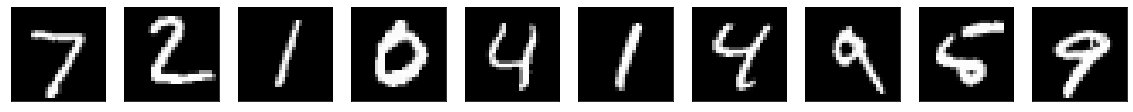

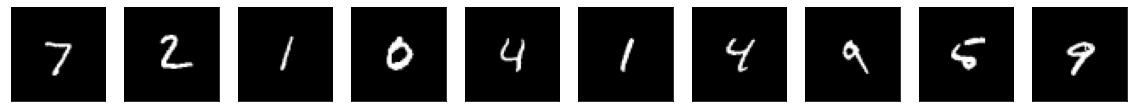

In [8]:
imprint(x_test)
x_train_pad = np.zeros((x_train_ex.shape[0], x_train_ex.shape[1]*2, x_train_ex.shape[2]*2), dtype='complex64')
x_test_pad = np.zeros((x_test_ex.shape[0], x_test_ex.shape[1]*2, x_test_ex.shape[2]*2), dtype='complex64')

for i in range(x_train.shape[0]):
    x_train_pad[i] = padding(x_train_ex[i])

for j in range(x_test.shape[0]):
    x_test_pad[j] = padding(x_test_ex[j])

imprint(x_test_pad.real)

### FFT変換

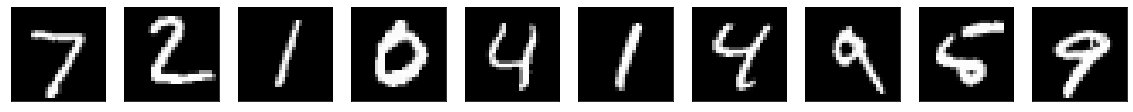

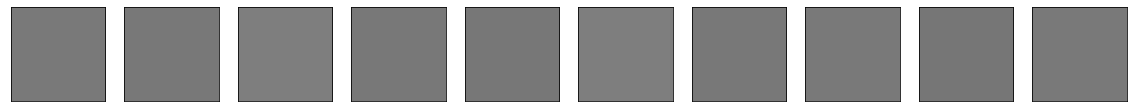

In [9]:
x_train_ft = np.zeros_like(x_train_pad)
x_test_ft = np.zeros_like(x_test_pad)

for i in range(x_train.shape[0]):
    x_train_ft[i] = np.fft.fft2(x_train_pad[i])
    
for j in range(x_test.shape[0]):
    x_test_ft[j] = np.fft.fft2(x_test_pad[j])

imprint(x_test)
imprint(x_test_ft.real)

### H行列計算

In [10]:
dx = dy = 8E-6
lam = 532E-9

z = 0.05
du = 1/(x_train_ft.shape[1]*dx)
dv = 1/(x_train_ft.shape[2]*dy)

In [11]:
size_x = x_train_ft.shape[1]
size_y = x_train_ft.shape[2]
H = np.zeros((size_x, size_y), dtype = np.complex64)

for n in range(size_x):
    for m in range(size_y):
        w = np.sqrt((1 / lam)**2
                     - (du * (m - size_x / 2))**2
                     - (dv * (n - size_y / 2))**2)
        H[n][m] = np.cos(2 * np.pi * z * w) + np.sin(2 * np.pi * z * w) * 1j

#象限変換
H_sft = np.fft.fftshift(H)

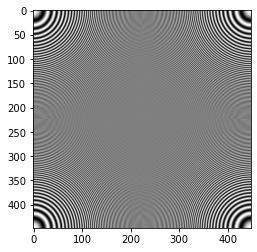

In [12]:
plt.imshow(H_sft.real)
plt.show()

## G×H計算

In [13]:
G_train = np.zeros(x_train_ft.shape, dtype=np.complex64)
G_test = np.zeros(x_test_ft.shape, dtype=np.complex64)

for i in range(x_train_ft.shape[0]):
    G_train[i] = x_train_ft[i] * H
    
for j in range(x_test_ft.shape[0]):
    G_test[j] = x_test_ft[j] * H


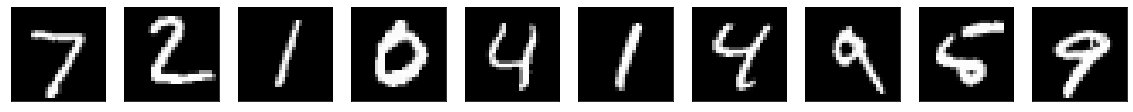

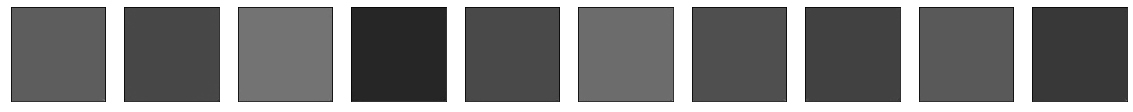

In [14]:
imprint(x_test)
imprint(G_test.real)

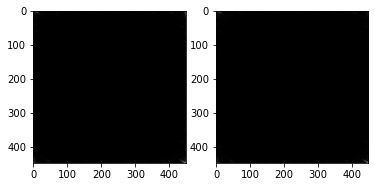

In [15]:
plt.subplot(121)
plt.imshow(abs(x_test_ft[0]))
plt.subplot(122)
plt.imshow(abs(G_test[0]))
plt.show()

### 逆FFT

In [16]:
g_train = np.zeros_like(G_train)
g_test = np.zeros_like(G_test)

for i in range(G_train.shape[0]):
    g_train[i] = np.fft.fft2(G_train[i])
    
for j in range(G_test.shape[0]):
    g_test[j] = np.fft.fft2(G_test[j])

### トリミング

In [17]:
def trim(f):
    #f2 = np.zeros((f.shape[0]/2, f.shape[1]/2), dtype=np.complex64)
    f2 = f[int(f.shape[0]/2-f.shape[0]/4):int(f.shape[0]/2+f.shape[0]/4), 
           int(f.shape[1]/2-f.shape[1]/4):int(f.shape[1]/2+f.shape[1]/4)]

    return f2

In [18]:
g_train_trim = np.zeros((g_train.shape[0], int(g_train.shape[1]/2), int(g_train.shape[2]/2)), dtype='float32')
g_test_trim = np.zeros((g_test.shape[0], int(g_test.shape[1]/2), int(g_test.shape[2]/2)), dtype='float32')

for i in range(g_train.shape[0]):
    g_train_trim[i] = abs(trim(g_train[i]))
    
for j in range(g_test.shape[0]):
    g_test_trim[j] = abs(trim(g_test[j]))

(10, 224, 224)
(10, 224, 224)


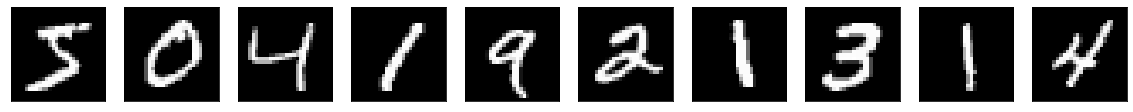

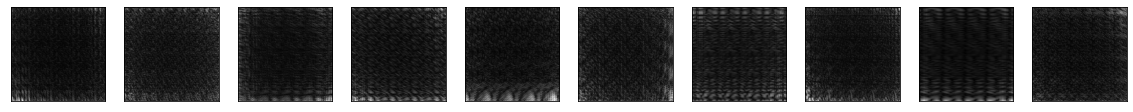

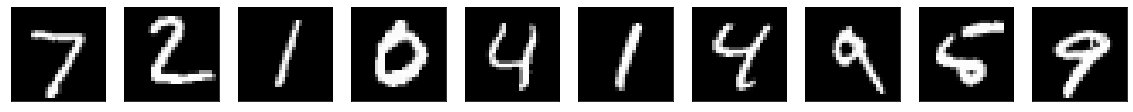

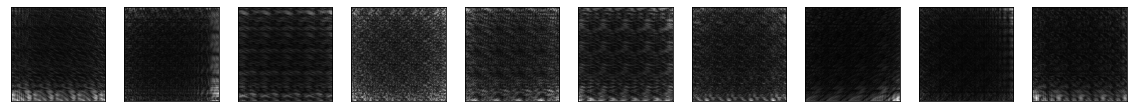

In [19]:
print(g_train_trim.shape)
print(g_test_trim.shape)

imprint(x_train)
imprint(g_train_trim)
imprint(x_test)
imprint(g_test_trim)

## MNIST学習

In [20]:
#初期値設定
image_x ,image_y = 28*ex, 28*ex   #画像サイズ
batch_size = 128 #バッチサイズ
input_shape = (image_x, image_y, 1)
num = 10 #0~9番号
epochs = 100

In [21]:
m_train = g_train_trim.reshape(g_train_trim.shape[0], g_train_trim.shape[1], g_train_trim.shape[2], 1)
m_test = g_test_trim.reshape(g_test_trim.shape[0], image_x, image_y, 1)

m_train = m_train.astype('float32') / 255
m_test = m_test.astype('float32') / 255

### ラベルデータをOne-hotベクトル形式に変換

In [22]:
from keras.utils import np_utils #エラー対策？
y_train = np_utils.to_categorical(y_train, num)
y_test = np_utils.to_categorical(y_test, num)

### モデルの作成

In [23]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

In [24]:
model = Sequential()
model.add(Conv2D(32,                                   #filter:フィルタの個数
                kernel_size = 3,                   #2次元(3,3)畳み込みウィンドウの幅と高さ
                activation = 'relu',                   
                input_shape = input_shape))            #入力shape
model.add(MaxPooling2D(pool_size = (2, 2)))            #領域内で最大値をとるモデル
model.add(Conv2D(64, (3,3), activation = 'relu'))      #relu:正規化線形関数
model.add(Dropout(0.25))
model.add(Flatten())                                   #特徴マップをベクトル形式に変換
model.add(Dense(num, activation = 'softmax'))          #softmax:0~1に確率変換
model.summary()

#損失関数・最適化関数、評価指数の指定とコンパイル
model.compile(loss = 'categorical_crossentropy', #損失関数 -> https://keras.io/objectives/
              optimizer = 'Adam', #評価関数 -> https://keras.io/optimizer/
              metrics = ['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 dropout (Dropout)           (None, 109, 109, 64)      0         
                                                                 
 flatten (Flatten)           (None, 760384)            0         
                                                                 
 dense (Dense)               (None, 10)                7603850   
                                                        

### モデルの学習

In [25]:
hist = model.fit(m_train, y_train,
                batch_size = batch_size,
                epochs = epochs,
                verbose = 1,
                validation_data = (m_test, y_test))
                #validation_split = 0.2) #検証用データの割合

Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 130.5384 - accuracy: 0.1000 - val_loss: 32366.7148 - val_accuracy: 0.2000
Epoch 2/100
1/1 [==============================] - 0s 63ms/step - loss: 24276.3223 - accuracy: 0.3000 - val_loss: 43574.6836 - val_accuracy: 0.2000
Epoch 3/100
1/1 [==============================] - 0s 59ms/step - loss: 35930.7656 - accuracy: 0.2000 - val_loss: 38556.3828 - val_accuracy: 0.0000e+00
Epoch 4/100
1/1 [==============================] - 0s 54ms/step - loss: 31867.8027 - accuracy: 0.1000 - val_loss: 24545.6328 - val_accuracy: 0.2000
Epoch 5/100
1/1 [==============================] - 0s 53ms/step - loss: 20482.1504 - accuracy: 0.1000 - val_loss: 13656.0029 - val_accuracy: 0.1000
Epoch 6/100
1/1 [==============================] - 0s 51ms/step - loss: 9805.0693 - accuracy: 0.2000 - val_loss: 6239.1392 - val_accuracy: 0.1000
Epoch 7/100
1/1 [==============================] - 0s 51ms/step - loss: 1603.7035 - accuracy: 0.6000 - val_loss: 1

In [26]:
#モデルの評価
score = model.evaluate(m_test, y_test)
print('Test loss:', score[0]) #損失
print('Test acc :', score[1]) #正解率

1/1 [==============================] - 0s 24ms/step - loss: 8993.5703 - accuracy: 0.0000e+00
Test loss: 8993.5703125
Test acc : 0.0


### グラフ化

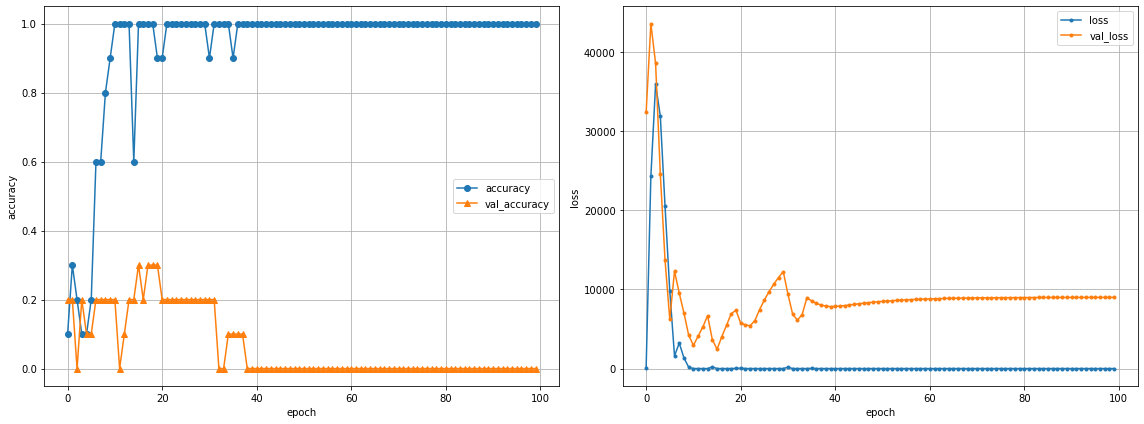

In [27]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(16, 6))
ax1 = fig.add_subplot(1, 2, 1, xlabel="epoch", ylabel="accuracy")
ax2 = fig.add_subplot(1, 2, 2, xlabel="epoch", ylabel="loss")

acc = hist.history['accuracy']
loss = hist.history['loss']
val_acc = hist.history['val_accuracy']
val_loss = hist.history['val_loss']

ax1.plot(range(len(acc)), acc, marker = 'o', label = 'accuracy')
ax1.plot(range(len(val_acc)), val_acc, marker = '^', label = 'val_accuracy')
ax1.legend(loc = 'best', fontsize = 10)
ax1.grid()
#ax1.xlabel('epoch')
#ax1.ylabel('accuracy')

ax2.plot(range(len(loss)), loss, marker = '.', label = 'loss')
ax2.plot(range(len(val_loss)), val_loss, marker = '.', label = 'val_loss')
ax2.legend(loc = 'best', fontsize = 10)
ax2.grid()
#ax2.xlabel('epoch')
#ax2.ylabel('loss')

plt.tight_layout()
plt.show()

fig.savefig("mnist_holo.png")

1/1 [==============================] - 0s 76ms/step


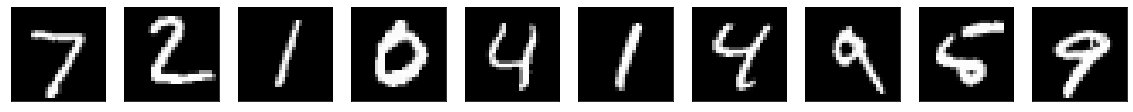

[3, 3, 3, 3, 3, 3, 3, 3, 3, 3]

In [28]:
result = model.predict(m_test)
label = []

imprint(x_test)

for i in range(10):
    index = np.argmax(result[i])
    label.append(index)
    
label